#### In this notebook I will modify the code of UniverSeg in order to see the effect of choosing a different support set
In UniverSeg the baseline score is based on chosing the first N items for the support set, making that the support set will always consist of the same images up to N=64 of a similar dog. This dog I1 has already ... scans, making ... image-label pairs. 
The support set is changed by looking at:
- Chosing the support set random from all Training images.
- Chosing a support set that consists out images of different dogs in a balanced manner by looking at the metadata. (Is this similar to random?)

In [2]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

import pathlib
import os
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple
from torch.utils.data import Dataset
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

cpu


In [4]:
#Training input images
support_input_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\Training\\training_input"
#Training without papillary muscle
support_output_nonpap_folder ="C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\Training\\training_withoutpap"
#Training with papillary muscle
support_output_pap_folder ="C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\Training\\training_withpap"

#Test input images
test_input_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\test_input"
#Test without papillary muscle
test_output_nonpap_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\test_withoutpap"
#Test with papillary muscle
test_output_pap_folder = "C:\\Users\\eveli\\OneDrive\\Documenten\\GitHub\\Thesis-EvelineKleijne\\Original data\\test_withpap"

In [5]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [6]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [7]:
#Accuracy score implemented
def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    correct = (y_pred == y_true).sum().item()
    total = y_true.numel()
    accuracy = correct / total
    
    return accuracy

In [8]:
def sensitivity_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum().item()
    sensitivity = true_positives / (true_positives + false_negatives) if true_positives + false_negatives != 0 else 0

    return sensitivity

In [9]:
def precision_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum().item()
    false_positives = ((y_pred == 1) & (y_true == 0)).sum().item()
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0

    return precision

In [10]:
def jaccard_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    intersection = ((y_pred == 1) & (y_true == 1)).sum().item()
    union = ((y_pred == 1) | (y_true == 1)).sum().item()
    jaccard = intersection / union if union != 0 else 0

    return jaccard

In [11]:
def process_image(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process input image."""
    img = PIL.Image.open(path)
    img = img.resize(size, resample=PIL.Image.BILINEAR)
    img = img.convert("L")  # Convert image to grayscale
    img = np.array(img, dtype=np.float32)
    return img 

def process_segmentation(path: pathlib.Path, size: Tuple[int, int]) -> np.ndarray:
    """Process segmentation mask."""
    seg = PIL.Image.open(path)
    seg = seg.resize(size, resample=PIL.Image.NEAREST)
    seg = np.array(seg)
    seg = np.expand_dims(seg == 255, axis=0)
    return seg.astype(np.float32)

def load_dataset(input_folder: str, label: str = None, size: Tuple[int, int] = (128, 128)):
    """Load dataset from folder with optional custom segmentation mask."""
    data = []
    input_path = pathlib.Path(input_folder)
    label_path = pathlib.Path(label) if label else None
    count = 1
    for file in sorted(input_path.glob("*.png")):
        img = process_image(file, size=size)
        

        # If label folder is provided, use the segmentation mask, otherwise, use None
        seg = None
        if label_path:
            seg_file = label_path / f"Segment{count:05}.png"
            if seg_file.exists():
                seg = process_segmentation(seg_file, size=size)
            else:
                print(f"Segmentation mask file '{seg_file}' not found. Skipping.")
        
        data.append((img / 256.0, seg))
        count+=1

    return data


class VentricleDataset(Dataset):
    def __init__(self, input_folder: str, label: str = None, size: Tuple[int, int] = (128, 128)):
        self.data = load_dataset(input_folder, label, size=size)
        T = torch.from_numpy
        self.data = [(T(x)[None], T(y)) for x, y in self.data]
        self.idxs = list(range(len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_img, seg = self.data[self.idxs[idx]]
        return input_img, seg

In [12]:
@torch.no_grad()
def inferencesupport(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    dicescore = dice_score(hard_pred, label)
    accuracy = accuracy_score(hard_pred,label)
    sensitivity =sensitivity_score(hard_pred,label)
    precision=precision_score(hard_pred,label)
    jaccard=jaccard_score(hard_pred,label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': dicescore,
            'accuracy' : accuracy,
            'sensitivity':sensitivity,
            'precision':precision,
            'jaccard' : jaccard}

In [13]:


#support_images, support_labels = zip(*itertools.islice(d_support, n_support))
#support_images = torch.stack(support_images).to(device)
#support_labels = torch.stack(support_labels).to(device)
import random
n_support = 64

d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)

# Create a list of indices
#indices = list(range(len(d_support)))

# Shuffle the indices
#random.shuffle(indices)

# Select n_support random indices
#random_indices = indices[:n_support]

# Use the selected random indices to extract corresponding elements from d_support
#random_support = [d_support[i] for i in random_indices]

# Unzip the random_support into images and labels
#support_images, support_labels = zip(*random_support)

# Convert support_images into a PyTorch tensor and move it to the device
#support_images = torch.stack(support_images).to(device)

In [14]:
import pandas as pd
import random

support_set_sizes = [1, 2, 4, 8, 16, 32, 64]

# Create empty DataFrames for each metric
df_dicescore = pd.DataFrame(columns=support_set_sizes)
df_accuracy = pd.DataFrame(columns=support_set_sizes)
df_sensitivity = pd.DataFrame(columns=support_set_sizes)
df_precision = pd.DataFrame(columns=support_set_sizes)
df_jaccard = pd.DataFrame(columns=support_set_sizes)

for image, label in d_test:
    dice_scores = {}
    acc = {}
    sens = {}
    prec = {}
    jac = {}
    for N in support_set_sizes:
        # Randomly select N indices for both images and labels
        random_indices = random.sample(range(len(d_support)), N)
        random_support = [(d_support[i][0], d_support[i][1]) for i in random_indices]
        
        # Unzip the random_support into images and labels
        support_images, support_labels = zip(*random_support)
        
        # Convert support_images into a PyTorch tensor and move it to the device
        support_images = torch.stack(support_images).to(device)
        support_labels = torch.stack(support_labels).to(device)
        
        # Call the function for inference
        vals = inferencesupport(model, image, label, support_images, support_labels)
        
        # Store the metrics
        dice_scores[N] = vals['score'] if 'score' in vals else None
        acc[N] = vals['accuracy'] if 'accuracy' in vals else None
        sens[N] = vals['sensitivity'] if 'sensitivity' in vals else None
        prec[N] = vals['precision'] if 'precision' in vals else None
        jac[N] = vals['jaccard'] if 'jaccard' in vals else None

    df_dicescore = pd.concat([df_dicescore, pd.DataFrame(dice_scores, index=[0])], ignore_index=True)
    df_accuracy = pd.concat([df_accuracy, pd.DataFrame(acc, index=[0])], ignore_index=True)
    df_sensitivity = pd.concat([df_sensitivity, pd.DataFrame(sens, index=[0])], ignore_index=True)
    df_precision = pd.concat([df_precision, pd.DataFrame(prec, index=[0])], ignore_index=True)
    df_jaccard = pd.concat([df_jaccard, pd.DataFrame(jac, index=[0])], ignore_index=True)

In [15]:
df_dicescore.to_csv('random_dicescore_with.csv', index=False)
df_accuracy.to_csv('random_accuracy_with.csv', index=False)
df_sensitivity.to_csv('random_sensitivity_with.csv', index=False)
df_precision.to_csv('random_precision_with.csv', index=False)
df_jaccard.to_csv('random_jaccard_with.csv', index=False)

In [17]:
meandice_df = pd.DataFrame(df_dicescore.mean().to_dict(),index=['DiceScore'])
meanacc_df = pd.DataFrame(df_accuracy.mean().to_dict(),index=['Accuracy'])
meansens_df=pd.DataFrame(df_sensitivity.mean().to_dict(),index=['Sensitivity'])
meanprec_df= pd.DataFrame(df_precision.mean().to_dict(),index=['Precision'])
meanjac_df = pd.DataFrame(df_jaccard.mean().to_dict(),index=['Jaccard'])

In [18]:
df=[meandice_df,meanacc_df,meansens_df,meanprec_df,meanjac_df]
result=pd.concat(df)
result

,1,2,4,8,16,32,64
DiceScore,0.575906,0.793173,0.868463,0.894652,0.909197,0.919214,0.921661
Accuracy,0.867108,0.923588,0.948818,0.959033,0.964604,0.968418,0.969421
Sensitivity,0.480965,0.781432,0.882055,0.905079,0.920486,0.933125,0.937947
Precision,0.749513,0.820690,0.860396,0.887967,0.900801,0.907423,0.907523
Jaccard,0.411733,0.666148,0.770461,0.810556,0.834241,0.850947,0.855031


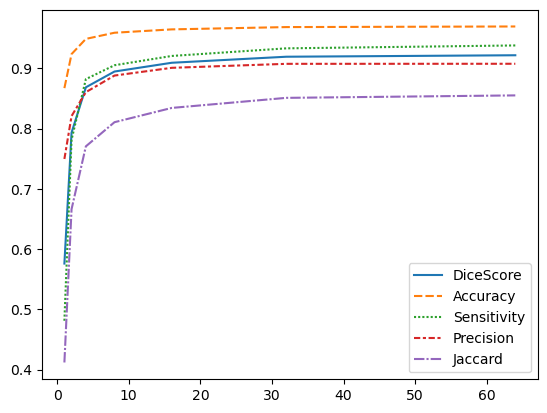

In [19]:
import seaborn as sns
sns.lineplot(result.transpose())
plt.show()

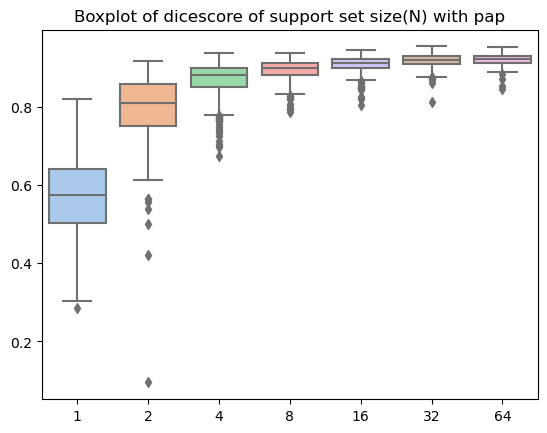

In [21]:
import seaborn as sns
#df_dicescore.plot(kind='box')
ax = sns.boxplot(data=df_dicescore, palette='pastel')
plt.title('Boxplot of dicescore of support set size(N) with pap')
plt.show()

### Ensemble with random support set

In [ ]:
d_support = VentricleDataset(support_input_folder, label=support_output_pap_folder)
d_test = VentricleDataset(test_input_folder, label=test_output_pap_folder)

support_sizes = [4,8,16,32,64]  # Adjust according to your requirements
n_ensemble_values = [3, 5, 8, 10]  # Adjust according to your requirements

# Initialize a dictionary to store average Dice scores
average_dice_scores = {}

# Iterate over different support sizes
for support_size in support_sizes:
    random_indices = random.sample(range(len(d_support)), N)
    random_support = [(d_support[i][0], d_support[i][1]) for i in random_indices]
        
    # Unzip the random_support into images and labels
    support_images, support_labels = zip(*random_support)
        
    # Convert support_images into a PyTorch tensor and move it to the device
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    # Iterate over different ensemble sizes
    for n_ensemble in n_ensemble_values:

        # get various support sets
        seeds = range(n_ensemble)
        supports = {
            seed: sample_support(seed)
            for seed in range(n_ensemble)
        }

        all_scores = []

        # go through the number of experiments
        for image, label in d_test:

            # Initialize a list to store scores for each ensemble
            ensemble_scores = []

            # go through the number of predictions we will ensemble
            for j in range(n_ensemble):
                # get support set
                #support_images, support_labels = sample_support(j)

                # perform inference
                vals = inference(model, image, label, support_images[:support_size], support_labels[:support_size])
                dice_score_value = vals['score'] if 'score' in vals else None
                ensemble_scores.append(dice_score_value)

            # Calculate the average score for this image across all ensembles
            average_score = sum(ensemble_scores) / n_ensemble

            # Append the score of this prediction to the list
            all_scores.append(average_score)

        # Calculate the average score across all predictions
        average_dice_score = sum(all_scores) / len(all_scores)

        # Store the average Dice score in the dictionary
        average_dice_scores[(support_size, n_ensemble)] = average_dice_score

# Print and/or save the dictionary as needed
print("Average Dice Scores:")
for key, value in average_dice_scores.items():
    print(f"Support Size: {key[0]}, Ensemble Size: {key[1]}, Average Dice Score: {value:.4f}")